In [1]:
import os
import zarr
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
fn_area = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_grid_area.zarr'
ds_area = xr.open_zarr(fn_area)
area_da = ds_area['c404_area']

In [4]:
varname_verif = ['WRF_precip', 'WRF_TMAX', 'WRF_TMIN']

In [5]:
# 'B1H', 'B3H', 'B6H'

for year in range(2021, 2025):
    for exp_name in ['GDAS',]:
        
        fn_pred = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/final_{exp_name}_{year}_WY_daily.zarr'
        ds_pred = xr.open_zarr(fn_pred)
        ds_pred = ds_pred[varname_verif]
        ds_mean_pred = ds_pred.weighted(area_da).mean(dim=("south_north", "west_east"), skipna=True)
        ds_mean_pred = ds_mean_pred.chunk({'time': 12})
        save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_{year}_daily.zarr'
        ds_mean_pred.to_zarr(save_name, mode='w', consolidated=True, compute=True)
        print(save_name)
        
    fn_true = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/target_{year}_WY_daily.zarr'
    ds_true = xr.open_zarr(fn_true)
    ds_true = ds_true[varname_verif]
    ds_mean_true = ds_true.weighted(area_da).mean(dim=("south_north", "west_east"), skipna=True)
    ds_mean_true = ds_mean_true.chunk({'time': 12})
    save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_{year}_daily.zarr'
    ds_mean_true.to_zarr(save_name, mode='w', consolidated=True, compute=True)
    print(save_name)

/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2021_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_2021_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2022_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_2022_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2023_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_2023_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2024_daily.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_2024_daily.zarr


In [10]:
# varname_verif = ['WRF_TMAX', 'WRF_TMIN']

# for year in range(2021, 2025):
#     for exp_name in ['GDAS', 'B1H', 'B3H', 'B6H']:
#         fn_pred = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/final_{exp_name}_{year}_WY_daily.zarr'
#         ds_pred = xr.open_zarr(fn_pred)
#         ds_pred = ds_pred[varname_verif]
#         raise
#         # ds_mean_pred = ds_pred.weighted(area_da).mean(dim=("south_north", "west_east"), skipna=True)
#         # ds_mean_pred = ds_mean_pred.chunk({'time': 12})
#         # save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_{year}_daily.zarr'
#         # ds_mean_pred.to_zarr(save_name, mode='w', consolidated=True, compute=True)
#         # print(save_name)
        
#     # fn_true = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/target_{year}_WY_daily.zarr'
#     # ds_true = xr.open_zarr(fn_true)
#     # ds_true = ds_true[varname_verif]
#     # ds_mean_true = ds_true.weighted(area_da).mean(dim=("south_north", "west_east"), skipna=True)
#     # ds_mean_true = ds_mean_true.chunk({'time': 12})
#     # save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_{year}_daily.zarr'
#     # ds_mean_true.to_zarr(save_name, mode='w', consolidated=True, compute=True)
#     # print(save_name)

## Monthly cycle

In [21]:
def annual_cycle_daily(
    rmse_ds, time_dim,
    tz=None, q=(0.10, 0.90),
):
    """
    Compute monthly (month-of-year) statistics of an hourly Dataset.

    Returns a Dataset with dims:
      - month: 1..12
      - stat: ["mean", "std", "p10", "p90"]  (or more if you pass more quantiles)
    Other, non-time dims are preserved (e.g., bottom_top, south_north, west_east).
    """
    """
    Compute day-of-year (DOY) statistics of a daily or hourly Dataset.

    Returns a Dataset with dims:
      - dayofyear: 1..366  (Feb 29 -> 60; absent => NaN after reindex)
      - stat: ["mean", "std", "p10", "p90"]  (or more if you pass more quantiles)

    Other, non-time dims are preserved (e.g., bottom_top, south_north, west_east).

    Notes
    -----
    * Hourly inputs: values from all hours of the same calendar day across years
      are pooled. If you want "daily-mean DOY" instead, first do:
          ds = rmse_ds.resample({time_dim: "1D"}).mean(skipna=True)
          return dayofyear_stats(ds, time_dim, tz=tz, q=q)
    """
    # Keep only numeric vars that depend on time
    ds = rmse_ds[[v for v, da in rmse_ds.data_vars.items()
                  if np.issubdtype(da.dtype, np.number) and (time_dim in da.dims)]]

    if ds.sizes.get(time_dim, 0) == 0:
        raise ValueError(f"No data along time dim '{time_dim}' to compute day-of-year stats.")

    # Prepare time coordinate (optionally convert to local time)
    t = ds[time_dim]
    if tz is not None:
        # If naive, localize to UTC then convert; if tz-aware, just convert
        try:
            t_local = t.dt.tz_localize("UTC").dt.tz_convert(tz)
        except Exception:
            t_local = t.dt.tz_convert(tz)
    else:
        t_local = t

    # --- Group by calendar month-day to avoid leap-year misalignment ---
    # Example labels: "01-01", "12-31", "02-29" (only in leap years)
    month_day = t_local.dt.strftime("%m-%d")
    month_day.name = "month_day"

    gb = ds.groupby(month_day)

    # Mean & std over time
    mean_d = gb.mean(dim=time_dim, skipna=True)
    std_d  = gb.std(dim=time_dim, skipna=True)

    # Quantiles
    q_arr = np.atleast_1d(q).astype(float)
    if np.any((q_arr < 0) | (q_arr > 1)):
        raise ValueError("All quantiles in `q` must be within [0, 1].")

    try:
        q_d = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                          dim=time_dim, skipna=True, method="linear")
    except TypeError:  # xarray<2023.08 uses 'interpolation'
        q_d = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                          dim=time_dim, skipna=True, interpolation="linear")

    # Build readable labels, e.g. 0.10 -> "p10", 0.025 -> "p2.5"
    def _q_label(qq: float) -> str:
        val = qq * 100.0
        if np.isclose(val, round(val)):
            return f"p{int(round(val))}"
        s = f"{val:.2f}".rstrip("0").rstrip(".")
        return f"p{s}"

    q_labels = [_q_label(qq) for qq in q_arr]

    # Put quantiles under a 'stat' coordinate
    q_part = q_d.rename({"quantile": "stat"}).assign_coords(stat=q_labels)

    # Put mean/std under 'stat' too and concatenate
    mean_std = xr.concat(
        [mean_d, std_d],
        dim=xr.IndexVariable("stat", ["mean", "std"])
    )
    out = xr.concat([mean_std, q_part], dim="stat")  # currently keyed by 'month_day'

    # --- Convert 'month_day' -> integer DOY labels using a leap year (2000) ---
    md = out["month_day"].astype(str).values  # e.g., ["01-01", "01-02", ...]
    doy = pd.to_datetime("2000-" + pd.Index(md)).dayofyear.to_numpy()
    out = out.assign_coords(month_day=("month_day", doy)).rename({"month_day": "dayofyear"})

    # Ensure DOY 1..366 in order (missing DOYs, e.g., 60 if no leap years, become NaN)
    out = out.sortby("dayofyear").reindex(dayofyear=np.arange(1, 367))

    # (Optional) make Zarr‑friendly small chunks on the new dims
    out = out.chunk({"stat": -1, "dayofyear": -1})

    return out


def annual_cycle_monthly(
    rmse_ds, time_dim,
    tz=None, q=(0.10, 0.90),
):
    """
    Compute monthly (month-of-year) statistics of an hourly Dataset.

    Returns a Dataset with dims:
      - month: 1..12
      - stat: ["mean", "std", "p10", "p90"]  (or more if you pass more quantiles)
    Other, non-time dims are preserved (e.g., bottom_top, south_north, west_east).
    """
    # Keep only numeric vars that depend on time
    ds = rmse_ds[[v for v, da in rmse_ds.data_vars.items()
                  if np.issubdtype(da.dtype, np.number) and (time_dim in da.dims)]]

    if ds.sizes.get(time_dim, 0) == 0:
        raise ValueError(f"No data along time dim '{time_dim}' to compute monthly stats.")

    # Prepare time coordinate (optionally convert to local time)
    t = ds[time_dim]
    if tz is not None:
        # If naive, localize to UTC then convert; if tz-aware, just convert
        try:
            t_local = t.dt.tz_localize("UTC").dt.tz_convert(tz)
        except Exception:
            t_local = t.dt.tz_convert(tz)
    else:
        t_local = t

    # Group by month-of-year
    gb = ds.groupby(t_local.dt.month)

    # Mean & std over time
    mean_m = gb.mean(dim=time_dim, skipna=True)
    std_m  = gb.std(dim=time_dim, skipna=True)

    # Quantiles
    q_arr = np.atleast_1d(q).astype(float)
    if np.any((q_arr < 0) | (q_arr > 1)):
        raise ValueError("All quantiles in `q` must be within [0, 1].")

    try:
        q_m = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                          dim=time_dim, skipna=True, method="linear")
    except TypeError:  # xarray<2023.08 uses 'interpolation'
        q_m = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                          dim=time_dim, skipna=True, interpolation="linear")

    # Build readable labels, e.g. 0.10 -> "p10", 0.025 -> "p2.5"
    def _q_label(qq: float) -> str:
        val = qq * 100.0
        if np.isclose(val, round(val)):
            return f"p{int(round(val))}"
        s = f"{val:.2f}".rstrip("0").rstrip(".")
        return f"p{s}"

    q_labels = [_q_label(qq) for qq in q_arr]

    # Put quantiles under a 'stat' coordinate
    q_part = q_m.rename({"quantile": "stat"}).assign_coords(stat=q_labels)

    # Put mean/std under 'stat' too and concatenate
    mean_std = xr.concat(
        [mean_m, std_m],
        dim=xr.IndexVariable("stat", ["mean", "std"])
    )
    out = xr.concat([mean_std, q_part], dim="stat")

    # Ensure months 1..12 in order (missing months become NaN)
    out = out.reindex(month=np.arange(1, 13))

    # (Optional) make Zarr‑friendly small chunks on the new dims
    out = out.chunk({"stat": -1, "month": -1})

    return out

In [22]:
# exp_name = 'B3H'
varname_diurnal = ['WRF_precip', 'WRF_TMAX', 'WRF_TMIN']

for exp_name in ['B1H', 'B3H', 'B6H', 'target']:
    
    ds_collection = []
    for year in range(2021, 2025):
        clim_ds = xr.open_zarr(f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_{year}_daily.zarr')
        clim_ds = clim_ds.chunk(dict(time=-1))
        ds_collection.append(clim_ds)
        
    ds_CLIM = xr.concat(ds_collection, dim='time')
    
    ds_month = annual_cycle_monthly(ds_CLIM, time_dim='time', q=[0.10, 0.90])
    save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_daily_annual_mon.zarr'
    ds_month.to_zarr(save_name, mode='w', consolidated=True, compute=True)
    print(save_name)
    
    ds_daily = annual_cycle_daily(ds_CLIM, time_dim='time', q=[0.10, 0.90])
    save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_daily_annual.zarr'
    ds_daily.to_zarr(save_name, mode='w', consolidated=True, compute=True)
    print(save_name)

/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_B1H_daily_annual_mon.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_B1H_daily_annual.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_B3H_daily_annual_mon.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_B3H_daily_annual.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_B6H_daily_annual_mon.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_B6H_daily_annual.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_daily_annual_mon.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_daily_annual.zarr


In [19]:
ds_month

<xarray.Dataset>
Dimensions:     (stat: 4, month: 12)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * stat        (stat) <U4 'mean' 'std' 'p10' 'p90'
Data variables:
    WRF_TMAX    (stat, month) float64 dask.array<chunksize=(4, 12), meta=np.ndarray>
    WRF_TMIN    (stat, month) float64 dask.array<chunksize=(4, 12), meta=np.ndarray>
    WRF_precip  (stat, month) float64 dask.array<chunksize=(4, 12), meta=np.ndarray>

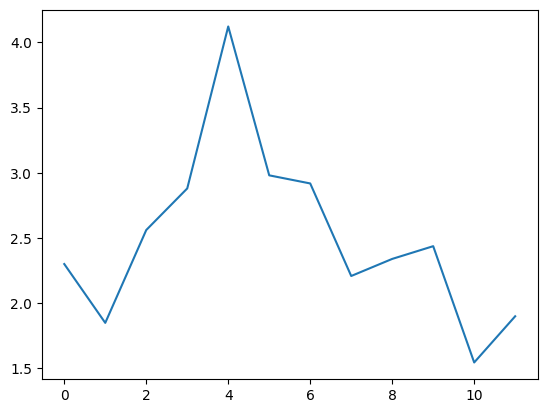

In [20]:
plt.plot(ds_month['WRF_precip'].values[0, :])

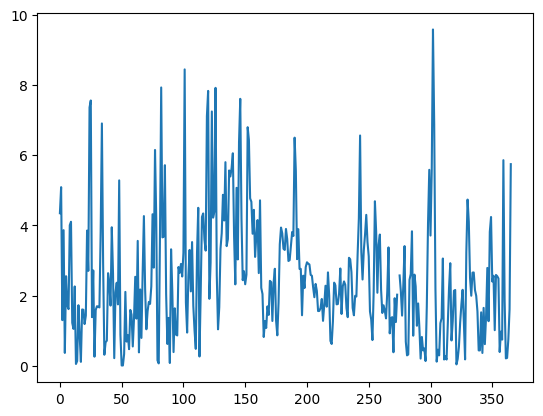

In [16]:
plt.plot(ds_month['WRF_precip'].values[0, :])